In [40]:
from langgraph.prebuilt import create_react_agent
from langchain_deepseek import ChatDeepSeek
from dotenv import load_dotenv
from typing import List, Dict, Any,TypedDict
import uuid 

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import Command,interrupt

load_dotenv()
# https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#pause-using-interrupt
# https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#patterns
# https://langchain-ai.github.io/langgraph/tutorials/get-started/4-human-in-the-loop/

True

In [31]:
class State(TypedDict):
    some_text: str

def human_node(state: State):
    value = interrupt({
        'text_to_revise': state['some_text']
    })
    return {'some_text': value}

graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

checkpointer = InMemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": 'thread_1'}}

result = graph.invoke({"some_text": "Hello, world!"}, config=config)

print(result['__interrupt__'])
    
print(graph.invoke(Command(resume="Edited text"), config=config)) 


[Interrupt(value={'text_to_revise': 'Hello, world!'}, resumable=True, ns=['human_node:f14cc7f6-727b-16d5-0614-86fd0170d4b1'])]
{'some_text': 'Edited text'}


In [20]:
result

{'some_text': 'Hello, world!',
 '__interrupt__': [Interrupt(value={'text_to_revise': 'Hello, world!'}, resumable=True, ns=['human_node:e6721fd7-e076-5eb3-ba14-cfe4ca85ca0b'])]}

In [41]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result)
# Output:
# Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, ...)

# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

{'llm_output': 'This is the generated output.', '__interrupt__': [Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, resumable=True, ns=['human_approval:1b143ea6-98f3-1554-7fa6-5c857e41597a'])]}
✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


In [42]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])
# Example output:
# Interrupt(
#   value={
#     'task': 'Please review and edit the generated summary if necessary.',
#     'generated_summary': 'The cat sat on the mat and looked at the stars.'
#   },
#   resumable=True,
#   ...
# )

# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, resumable=True, ns=['human_review_edit:bd593371-0567-ef6c-ae37-c11e96b98dd0'])]
✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


In [3]:
llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=1,
    timeout=None,
    max_retries=2,
    )

In [33]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [38]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

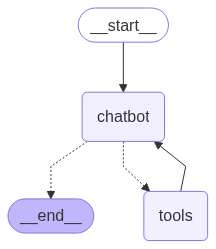

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0_5198bbaa-a906-4e25-af01-55a1a0aeb90c)
 Call ID: call_0_5198bbaa-a906-4e25-af01-55a1a0aeb90c
  Args:
    query: I need expert guidance for building an AI agent.


In [37]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [24]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
    "can you search the LangGraph in web an give a detail answer"
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_0_bb59d6ce-e99c-4f69-921f-f37ad66d716f)
 Call ID: call_0_bb59d6ce-e99c-4f69-921f-f37ad66d716f
  Args:
    query: I need expert guidance for building an AI agent. Could you connect me with a specialist who can assist with the development process, including design, implementation, and deployment?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.can you search the LangGraph in web an give a detail answer
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_0_23482ccc-24b1-4ff6-acf3-329fd12e0cb8)
 Call ID: call_0_23482ccc-24b1-4ff6-acf3-329fd12e0cb8
  Args:
    query: LangGraph
    search_depth: ad

In [20]:
user_input='introduce the deepseek model'
events = graph.invoke(    {"messages": [{"role": "user", "content": user_input}]},config,)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

TypeError: string indices must be integers, not 'str'

In [43]:
llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=1,
    timeout=None,
    max_retries=2,
    )


In [45]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_react_agent(
    model=llm,
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

In [46]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_3554361c-bc12-405f-9c5a-978ccad48cf7', 'function': {'arguments': '{"hotel_name":"McKittrick hotel"}', 'name': 'book_hotel'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 111, 'total_tokens': 146, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 111}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a7560eb-a56a-4d12-a075-a7e3476eb846-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'call_0_3554361c-bc12-405f-9c5a-978ccad48cf7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 111, 'output_tokens': 35, 'total_tokens': 146, 'input_token_details': {'cache_r

In [47]:
from langgraph.types import Command

for chunk in agent.stream(
    Command(resume={"type": "accept"}),  
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick hotel.', name='book_hotel', id='cba6be42-894e-4cd0-b9c9-a4b70f9b813e', tool_call_id='call_0_3554361c-bc12-405f-9c5a-978ccad48cf7')]}}


{'agent': {'messages': [AIMessage(content="Your stay at the McKittrick hotel has been successfully booked! Let me know if there's anything else you'd like to arrange.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 153, 'total_tokens': 180, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 64}, 'prompt_cache_hit_tokens': 64, 'prompt_cache_miss_tokens': 89}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'finish_reason': 'stop', 'logprobs': None}, id='run--0e5ba368-4710-40fe-bcfe-f4ccc180f020-0', usage_metadata={'input_tokens': 153, 'output_tokens': 27, 'total_tokens': 180, 'input_token_details': {'cache_read'

In [48]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

# Define graph state
class State(TypedDict):
    age: int

# Node that asks for human input and validates it
def get_valid_age(state: State) -> State:
    prompt = "Please enter your age (must be a non-negative integer)."

    while True:
        user_input = interrupt(prompt)

        # Validate the input
        try:
            age = int(user_input)
            if age < 0:
                raise ValueError("Age must be non-negative.")
            break  # Valid input received
        except (ValueError, TypeError):
            prompt = f"'{user_input}' is not valid. Please enter a non-negative integer for age."

    return {"age": age}

# Node that uses the valid input
def report_age(state: State) -> State:
    print(f"✅ Human is {state['age']} years old.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("get_valid_age", get_valid_age)
builder.add_node("report_age", report_age)

builder.set_entry_point("get_valid_age")
builder.add_edge("get_valid_age", "report_age")
builder.add_edge("report_age", END)

# Create the graph with a memory checkpointer
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run the graph until the first interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])  # First prompt: "Please enter your age..."

# Simulate an invalid input (e.g., string instead of integer)
result = graph.invoke(Command(resume="not a number"), config=config)
print(result["__interrupt__"])  # Follow-up prompt with validation message

# Simulate a second invalid input (e.g., negative number)
result = graph.invoke(Command(resume="-10"), config=config)
print(result["__interrupt__"])  # Another retry

# Provide valid input
final_result = graph.invoke(Command(resume="25"), config=config)
print(final_result)  # Should include the valid age

[Interrupt(value='Please enter your age (must be a non-negative integer).', resumable=True, ns=['get_valid_age:8bff879a-ed1e-e0bd-8c0e-5ff98d0ae8f6'])]
[Interrupt(value="'not a number' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:8bff879a-ed1e-e0bd-8c0e-5ff98d0ae8f6'])]
[Interrupt(value="'-10' is not valid. Please enter a non-negative integer for age.", resumable=True, ns=['get_valid_age:8bff879a-ed1e-e0bd-8c0e-5ff98d0ae8f6'])]
✅ Human is 25 years old.
{'age': 25}
